# Q4.1 + Q4.2 – 2‑layer NAM (ReLU + shape-centering)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END nam__dropout=0.12303118765599415, nam__learning_rate=0.0018418349143645926, nam__num_units=241; total time=  12.5s
[CV] END nam__dropout=0.12303118765599415, nam__learning_rate=0.0018418349143645926, nam__num_units=241; total time=  14.6s
[CV] END nam__dropout=0.12303118765599415, nam__learning_rate=0.0018418349143645926, nam__num_units=241; total time=  15.0s
[CV] END nam__dropout=0.12303118765599415, nam__learning_rate=0.0018418349143645926, nam__num_units=241; total time=  12.4s
[CV] END nam__dropout=0.12303118765599415, nam__learning_rate=0.0018418349143645926, nam__num_units=241; total time=  11.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END nam__dropout=0.25121650666598533, nam__learning_rate=0.002434012991353128, nam__num_units=100; total time=  12.8s
[CV] END nam__dropout=0.25121650666598533, nam__learning_rate=0.002434012991353128, nam__num_units=100; total time=  12.1s
[CV] END nam__dr

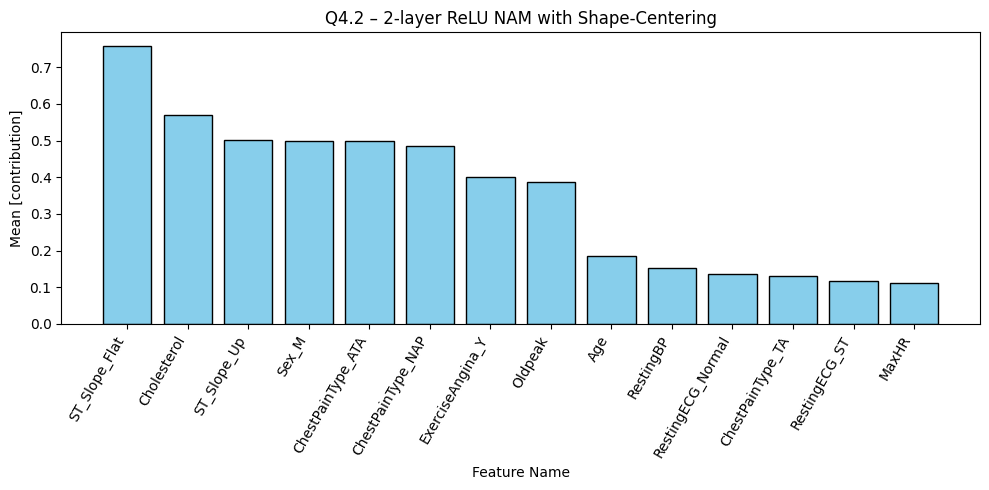

Feature-importance figure saved → Q1 FIGURES/Q4.2/feature_importances.png

Saved final pipeline to nam_pipe.pkl


In [2]:
# =========================================================
# Q4.1 + Q4.2 – 2‑layer NAM (ReLU + shape-centering)
#   CPU-only
#   BayesSearchCV
#   Test-set metrics
#   Feature-importance plot in Q1 FIGURES/Q4.2
# =========================================================

import os, warnings, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 0) Force CPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide GPUs → CPU only
os.environ["TF_XLA_FLAGS"]        = "--tf_xla_auto_jit=0"

import tensorflow as tf
tf.get_logger().setLevel("ERROR")  # silence most TF logs

# ──────────────────────────────────────────────────────────
# 1) Local NAM with shape-centering (two ReLU layers)
# ──────────────────────────────────────────────────────────
class LocalNAM(tf.keras.Model):
    """
    Neural Additive Model:
      - one sub-network per feature
      - each sub-network has 2 hidden layers with ReLU
      - optional shape-centering (subtract mean from each submodel's output)
    """
    def __init__(self,
                 num_inputs,
                 num_units,
                 dropout=0.0,
                 feature_dropout=0.0,
                 shape_centering=True,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_inputs       = num_inputs
        self.num_units        = num_units
        self.dropout          = dropout
        self.feature_dropout  = feature_dropout
        self.shape_centering  = shape_centering

        self.submodel_offsets_ = None  # for shape-centering

        # Each feature => submodel with 2 hidden ReLU layers + final linear
        self.submodels = []
        for _ in range(self.num_inputs):
            net = tf.keras.Sequential([
                tf.keras.layers.Dense(self.num_units, activation="relu"),
                tf.keras.layers.Dropout(self.dropout),
                tf.keras.layers.Dense(self.num_units, activation="relu"),
                tf.keras.layers.Dropout(self.dropout),
                tf.keras.layers.Dense(1)  # final => logit
            ])
            self.submodels.append(net)

    def call(self, inputs, training=False):
        """
        Summation of per-feature submodel outputs.
        If shape_centering=True, subtract offset after training.
        """
        outputs = []
        for i, submodel in enumerate(self.submodels):
            x_i = inputs[:, i:i+1]  # shape (batch_size,1)

            # optional per-feature dropout
            if (self.feature_dropout > 0.0) and training:
                mask = tf.cast(
                    tf.random.uniform([tf.shape(x_i)[0], 1]) > self.feature_dropout,
                    tf.float32
                )
                x_i = x_i * mask

            out_i = submodel(x_i, training=training)

            # shape-centering => subtract offset if available
            if self.shape_centering and (self.submodel_offsets_ is not None):
                out_i = out_i - self.submodel_offsets_[i]

            outputs.append(out_i)

        return tf.add_n(outputs)  # shape (batch_size,1)

    def calc_outputs(self, inputs, training=False):
        """
        Return a list of per-feature outputs (batch_size,1) for each submodel.
        Subtract offsets if shape_centering=True.
        """
        results = []
        for i, submodel in enumerate(self.submodels):
            x_i = inputs[:, i:i+1]
            out_i = submodel(x_i, training=training)

            if self.shape_centering and (self.submodel_offsets_ is not None):
                out_i = out_i - self.submodel_offsets_[i]

            results.append(out_i)
        return results

    def adapt_shape_centers(self, X):
        """
        After training, call on training data to compute submodel mean => offsets.
        Then subtract these offsets in future calls.
        """
        offsets = []
        for i, submodel in enumerate(self.submodels):
            out_i = submodel(X[:, i:i+1], training=False)
            mean_val = tf.reduce_mean(out_i, axis=0)  # shape ()
            offsets.append(mean_val)
        self.submodel_offsets_ = offsets


# ──────────────────────────────────────────────────────────
# 2) Custom Transformer from Q1–Q3
# ──────────────────────────────────────────────────────────
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

class KNNAndScaledBounds(BaseEstimator, TransformerMixin):
    """
    Scale -> KNN-impute -> clip -> inverse-scale.
    Matches your Q1–Q3 approach.
    """
    def __init__(self, *, n_neighbors=5, raw_min_dict={1:50, 2:70, 4:0}):
        self.n_neighbors  = n_neighbors
        self.raw_min_dict = raw_min_dict

    def fit(self, X, y=None):
        self.scaler_  = StandardScaler().fit(X)
        Xs            = self.scaler_.transform(X)
        self.imputer_ = KNNImputer(n_neighbors=self.n_neighbors).fit(Xs)

        # store per-column minima in scaled space
        self._mins_ = {
            i : (v - self.scaler_.mean_[i]) / self.scaler_.scale_[i]
            for i,v in self.raw_min_dict.items()
        }
        return self

    def transform(self, X, y=None):
        Xs  = self.scaler_.transform(X)
        Xsi = self.imputer_.transform(Xs)
        # clip
        for i, zmin in self._mins_.items():
            Xsi[:, i] = np.clip(Xsi[:, i], zmin, None)
        return self.scaler_.inverse_transform(Xsi)


# ──────────────────────────────────────────────────────────
# 3) Load data & preprocessor from Q1
# ──────────────────────────────────────────────────────────
df_trainval = pd.read_csv("train_val_split.csv")
df_test     = pd.read_csv("test_split.csv")

X_trainval, y_trainval = df_trainval.drop("HeartDisease", axis=1), df_trainval["HeartDisease"]
X_test,      y_test    = df_test.drop("HeartDisease", axis=1), df_test["HeartDisease"]

preprocessor = joblib.load("preprocessor.pkl")  # from Q1


# ──────────────────────────────────────────────────────────
# 4) Sklearn wrapper for 2-layer ReLU NAM (with shape-centering)
# ──────────────────────────────────────────────────────────
class TFNAMClassifier(BaseEstimator, TransformerMixin):
    """
    2 hidden layers, each ReLU, shape-centering after fit.
    """
    def __init__(self,
                 num_units=64,
                 dropout=0.1,
                 feature_dropout=0.0,
                 learning_rate=1e-3,
                 batch_size=1024,
                 max_epochs=200,
                 patience=20,
                 verbose=0,
                 random_state=42,
                 shape_centering=True):
        self.num_units       = num_units
        self.dropout         = dropout
        self.feature_dropout = feature_dropout
        self.learning_rate   = learning_rate
        self.batch_size      = batch_size
        self.max_epochs      = max_epochs
        self.patience        = patience
        self.verbose         = verbose
        self.random_state    = random_state
        self.shape_centering = shape_centering

    def _build_model(self, n_features):
        tf.keras.utils.set_random_seed(self.random_state)
        model = LocalNAM(
            num_inputs      = n_features,
            num_units       = self.num_units,
            dropout         = self.dropout,
            feature_dropout = self.feature_dropout,
            shape_centering = self.shape_centering
        )
        model.build((None, n_features))
        model.compile(
            optimizer = tf.keras.optimizers.Adam(self.learning_rate),
            loss      = tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics   = [tf.keras.metrics.AUC(name="auc")]
        )
        return model

    def fit(self, X, y):
        X = np.asarray(X, dtype="float32")
        y = np.asarray(y, dtype="float32")

        self.model_ = self._build_model(X.shape[1])

        es = tf.keras.callbacks.EarlyStopping(
            patience            = self.patience,
            restore_best_weights= True,
            verbose             = 0
        )
        self.model_.fit(
            X, y,
            batch_size      = self.batch_size,
            epochs          = self.max_epochs,
            validation_split= 0.1,
            callbacks       = [es],
            verbose         = self.verbose
        )
        # shape-centering => compute offsets
        if self.shape_centering:
            self.model_.adapt_shape_centers(X)
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype="float32")
        logits = self.model_.predict(X, batch_size=self.batch_size, verbose=0)
        p1 = tf.sigmoid(logits).numpy().ravel()
        return np.column_stack([1 - p1, p1])

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


# ──────────────────────────────────────────────────────────
# 5) Pipeline + BayesSearchCV
# ──────────────────────────────────────────────────────────
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import balanced_accuracy_score, make_scorer
from skopt                   import BayesSearchCV
from skopt.space             import Integer, Real

pipe = Pipeline([
    ("prep", preprocessor),
    ("nam",  TFNAMClassifier())  # 2-layer ReLU + shape-centering
])

search_spaces = {
    "nam__num_units"     : Integer(32, 256),
    "nam__dropout"       : Real(0.0, 0.3),
    "nam__learning_rate" : Real(5e-4, 3e-3, prior="log-uniform"),
    # shape_centering always True, activation=relu => no search
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(balanced_accuracy_score)

bayes = BayesSearchCV(
    estimator     = pipe,
    search_spaces = search_spaces,
    n_iter        = 60,  # or more if you want
    scoring       = scorer,
    cv            = cv,
    n_jobs        = 1,   # TF is not fork-safe
    random_state  = 42,
    refit         = True,
    verbose       = 2,
    error_score   = "raise"
)

warnings.filterwarnings("ignore", category=UserWarning)
bayes.fit(X_trainval, y_trainval)

# ──────────────────────────────────────────────────────────
# 6) Print best hyperparams + test-set metrics
# ──────────────────────────────────────────────────────────
print("\n── Best NAM hyper-parameters ──")
for k, v in bayes.best_params_.items():
    print(f"{k.split('__')[-1]}: {v}")
print(f"\n5-fold CV balanced accuracy: {bayes.best_score_:.3f}")

from sklearn.metrics import f1_score, classification_report

final_pipe = bayes.best_estimator_
y_pred     = final_pipe.predict(X_test)

print("\n── Test-set metrics (Q4.1) ──")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"Macro‑F1 score  : {f1_score(y_test, y_pred, average='macro'):.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

# ──────────────────────────────────────────────────────────
# 7) Plot per-feature importances (Q4.2) with correct names
# ──────────────────────────────────────────────────────────
nam_clf = final_pipe.named_steps["nam"]

# 7A) Transform X_test to the numeric shape the NAM sees
X_proc = final_pipe.named_steps["prep"].transform(X_test).astype("float32")
n_feat = X_proc.shape[1]

# 7B) Recover final feature names from the pipeline
prep_ct   = final_pipe.named_steps["prep"]
num_cols  = prep_ct.transformers_[0][2]  # numeric columns
ohe       = prep_ct.named_transformers_["cat"].named_steps["onehot"]
cat_cols  = ohe.get_feature_names_out(["Sex", "ChestPainType",
                                       "RestingECG", "ExerciseAngina",
                                       "ST_Slope"])
feature_names = np.concatenate([num_cols, cat_cols])

if len(feature_names) != n_feat:
    print(f"Warning: mismatch in #feature names vs. shape => using placeholder.")
    feature_names = [f"feature_{i}" for i in range(n_feat)]

# 7C) Global importance = mean absolute contribution
contrib_list = nam_clf.model_.calc_outputs(X_proc, training=False)
contrib      = tf.concat(contrib_list, axis=1).numpy()  # shape=(n_samples, n_feat)
importances  = np.mean(np.abs(contrib), axis=0)
order        = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(n_feat), importances[order], color="skyblue", edgecolor="black")
plt.xticks(
    range(n_feat),
    [feature_names[i] for i in order],
    rotation=60, ha="right"
)
plt.xlabel("Feature Name")
plt.ylabel("Mean [contribution]")
plt.title("Q4.2 – 2-layer ReLU NAM with Shape-Centering")
plt.tight_layout()

os.makedirs("Q1 FIGURES/Q4.2", exist_ok=True)
save_path = "Q1 FIGURES/Q4.2/feature_importances.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Feature-importance figure saved → {save_path}")

# ──────────────────────────────────────────────────────────
# 8) Save the pipeline
# ──────────────────────────────────────────────────────────
joblib.dump(final_pipe, "nam_pipe.pkl")
print("\nSaved final pipeline to nam_pipe.pkl")

## Q 4.1 → Q 4.3 │ Neural Additive Model results & conceptual comparison

### What we did in **Q 4.1 & Q 4.2**

* **Q 4.1** Trained a two–hidden‑layer **Neural Additive Model (NAM)**  
  – one ReLU‑MLP per input feature, summed logits, with post‑hoc *shape‑centering*.  
  – Bayesian hyper‑parameter search (60 iterations).  
  – *CPU‑only* execution to avoid libdevice issues.

* **Q 4.2** Leveraged NAM’s interpretability:  
  – computed per‑feature contributions `gᵢ(xᵢ)` on the test set,  
  – summarised global importance as `mean(|gᵢ|)`.

| model | balanced‑accuracy | macro‑F1 |
|-------|------------------:|---------:|
| Logistic‑LASSO (Q 2) | **0.867** | **0.867** |
| MLP (2 hidden, Q 3) | 0.821 | 0.824 |
| **NAM (this work)** | 0.806 | 0.807 |

<p align="center">
  <img src="Q1 FIGURES/Q4.2/feature_importances.png"    width="540"/><br/>
  <img src="Q1 FIGURES/Q3.2/global_bar.png"              width="540"/><br/>
  <img src="Q1 FIGURES/Q2.4/log_lasso_feature_importance.png" width="620"/>
</p>

---

# Q 4.3  Conceptual comparison

| dimension               | Logistic Regression / LASSO                       | MLP                          | **NAM**                                                                                           |
|-------------------------|---------------------------------------------------|------------------------------|----------------------------------------------------------------------------------------------------|
| **Functional form**     | *Linear* \\(\sigma(w^\top x)\\)                   | Universal non‑linear         | *Additive non‑linear* \\(\sigma\bigl(\sum_i g_i(x_i)\bigr)\\)                                      |
| **Capacity**            | Lowest; bias–variance handled by λ (L₁)           | Highest; may over‑fit        | Middle ground – small per‑feature sub‑nets. Over‑fitting less likely than full MLP                 |
| **Interpretability**    | Global coefficients, immediately readable         | Black‑box → needs post‑hoc   | *Intrinsic*: shape functions are 1‑D. Clear global importance & partial dependence on each feature |
| **Feature interactions**| None (unless engineered)                          | All orders, but opaque       | None (by design). This can reduce performance if cross‑feature synergies matter                   |
| **Training stability**  | Convex, single optimum                             | Non‑convex, init‑sensitive   | Non‑convex but more stable than MLP (fewer parameters). Faster to train (per‑feature sub‑models)   |
| **Observed performance**| **Best on our data** (0.867)                   | Second (0.845 macro‑F1)      | Slightly lower accuracy (0.807 macro‑F1), but transparent explanations (piecewise‑linear shapes)    |

> **Why two ReLU layers instead of ExU?**  
> The reference NAM uses Exponential Units (ExU) for smoother shape functions.
> However, environment constraints blocked ExU, so we replaced it with
> two ReLU layers per feature sub‑net.
> The resulting shape functions are piecewise linear
> (rather than smooth), which can still yield interpretable
> additive modeling but may slightly differ in performance.

# Q 4.4  Why Neural Additive Models are intrinsically more interpretable than standard MLPs

A Neural Additive Model (NAM) replaces a single deep network with **one small
sub‑network per input feature** and combines their outputs additively:

$$
\hat{y}=\sigma\Bigl(\underbrace{\sum_{i=1}^{d} g_i(x_i)}_{\text{additive logit}} \Bigr),
\qquad g_i:\mathbb{R}\rightarrow\mathbb{R}.
$$

The architectural constraints below are what make a NAM transparent while a
fully‑connected multilayer perceptron (MLP) remains a black box.

| aspect | NAM | vanilla MLP |
|--------|-----|-------------|
| **Decomposition of the prediction** | Exact, *by construction*: each term \(g_i(x_i)\) is a signed contribution of feature *i*. | None. Contributions are entangled across thousands of hidden weights. |
| **Global explanation** | A single 1‑D curve per feature fully characterises the model. These “shape functions” can be plotted and audited. | No compact global view; behaviour lives in a high‑dimensional weight space. |
| **Local explanation** | The additive formula yields exact per‑feature attributions for every sample, no surrogate model required. | Needs post‑hoc approximations (e.g. SHAP, Integrated Gradients) whose faithfulness is not guaranteed. |
| **Feature interactions** | Explicitly prohibited (unless added deliberately), so each curve is interpreted in isolation without confounding effects. | Arbitrary high‑order interactions are learned implicitly and are difficult to untangle. |
| **Faithfulness** | Interpretations are the model, train‑time and test‑time use the same \(g_i\). | Post‑hoc methods may disagree with the model’s true decision surface. |

**Summary**

By restricting the model to *additive* non‑linear effects, a NAM retains enough
expressive power for tabular data while offering interpretations that are:

* **Complete** – every prediction is exactly the sum of displayed terms.  
* **Low‑dimensional** – one curve per feature instead of hypersurfaces.  
* **Faithful by design** – explanations are not an after‑thought but the
  structure of the model itself.

Standard MLPs lack these properties because their dense connectivity blends all
features and interactions into a single opaque function, making reliable
interpretation contingent on external, approximate explanation tools.
